<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
from pytorch_metric_learning import losses, miners, distances, reducers, samplers
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn

In [32]:
from code.dataloader import AgeGroupMLDataset, AgeGroupClfDataset
from code.encoder_gru import Encoder
from code.decoder import Decoder
from code.classifier import Classifier
from code.utils import train_ml_model, train_classifier

In [53]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
NUM_OF_SUBSEQUENCES = 5
SUBSEQUENCE_LENGTH = 90

EMBEDDING_DIM = 256
LR = 0.002
NUM_EPOCHS = 150

cat_vocab_sizes = [204]
num_input_dim = 4
ARCH = 'GRU'
NUM_OBS = 30000

In [54]:
dataset = AgeGroupMLDataset(num_observations=NUM_OBS)

In [36]:
dataset.load_client_to_indices()

In [37]:
import random

In [38]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [39]:
targets = dataset.targets

In [42]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

In [43]:
encoder = Encoder(
    numerical_input_dim=num_input_dim,
    cat_vocab_sizes=cat_vocab_sizes,
    embedding_dim=EMBEDDING_DIM,
)
encoder.to(device);

In [44]:
optimizer = optim.Adam(encoder.parameters(), lr=LR)

In [45]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")

# sota
# loss_func = losses.ArcFaceLoss(
#     num_classes=len(targets), embedding_size=EMBEDDING_DIM,
#     distance=distance).to(torch.device('cuda')) # not sure why we need to move it to cuda

In [46]:
NUM_EPOCHS = 20

In [47]:
train_losses = train_ml_model(
    encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
    mining_func, loss_func, optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss = 0.19200477004051208
Epoch 1 Loss = 0.1579761952161789
Epoch 2 Loss = 0.14315466582775116
Epoch 3 Loss = 0.13521263003349304
Epoch 4 Loss = 0.12200845777988434
Epoch 5 Loss = 0.09750757366418839
Epoch 6 Loss = 0.08745983988046646
Epoch 7 Loss = 0.08339504897594452
Epoch 8 Loss = 0.07456379383802414
Epoch 9 Loss = 0.0743306577205658
Epoch 10 Loss = 0.07288981974124908
Epoch 11 Loss = 0.05934583768248558
Epoch 12 Loss = 0.05867350473999977
Epoch 13 Loss = 0.05798571929335594
Epoch 14 Loss = 0.05440289527177811
Epoch 15 Loss = 0.06087564304471016
Epoch 16 Loss = 0.05188200622797012
Epoch 17 Loss = 0.05108228698372841
Epoch 18 Loss = 0.05135320499539375
Epoch 19 Loss = 0.04759916663169861


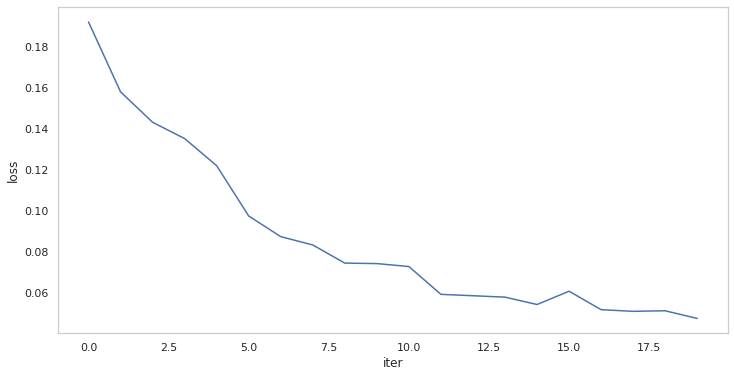

In [48]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.plot(train_losses, label='train')
plt.xlabel('iter')
plt.ylabel('loss');

In [ ]:
plt.savefig(f'plots/{ARC}_{EMBEDDING_DIM}_{NUM_OBS}.png')

comparison of encoders
* LSTM
* GRU
* Transformer

comparison for embedding size

# Train classifier

In [ ]:
classifier = Classifier(
    numerical_input_dim=num_input_dim,
    cat_vocab_sizes=cat_vocab_sizes,
    embedding_dim=EMBEDDING_DIM
)

In [ ]:
classifier.encoder = encoder

In [ ]:
classifier.freeze_encoder()

In [ ]:
classifier.to(device);

In [ ]:
clfdataset = AgeGroupClfDataset()

In [ ]:
clfdataset.load_client_to_indices()

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
targets = clfdataset.targets

train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets,
    random_state=228
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
testloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=test_sampler)

In [ ]:
clfdataloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

In [ ]:
SCHEDULER_EPOCHS = 2

In [ ]:
LR = 0.0005

In [ ]:
optimizer = optim.Adam(classifier.decoder.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=SCHEDULER_EPOCHS,
)

In [ ]:
NUM_EPOCHS = 20

In [ ]:
train_losses, train_accuracy, val_losses, val_accuracy = train_classifier(
    classifier, NUM_EPOCHS, trainloader, testloader,
    optimizer, criterion, scheduler,
    enable_train_mode = lambda: classifier.decoder.train(),
    enable_test_mode = lambda: classifier.decoder.eval(),
)

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('iter')
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='validation')
plt.legend()
plt.ylabel('accuracy');

# Predict (old)

In [ ]:
m = encoder.to('cpu').eval()

In [ ]:
# check
dataiter = iter(dataloader)
sequences, labels = dataiter.next()

# should be BATCH_SIZExNUM_OF_SEQUNCESxSUBSEQUENCE_LENGTHx(num_features)
sequences.shape

In [ ]:
embeddings = torch.zeros((1, EMBEDDING_DIM))[1:]

# probably can make it faster if use a batch of clients
for client_id in tqdm(sorted(dataset.targets)):
    n, c = dataset.get_sequence(client_id)

    with torch.no_grad():
        embedding = m(n, c)
        # encoded_events = m.event_encoder(n, c)
        # encoded_events = encoded_events.view(1, -1, EMBEDDING_DIM)
        # encoded_events = torch.transpose(encoded_events, 0, 1) # so that its (seq_len, batch, input_size)
        # embedding = m.sequence_encoder(encoded_events)[0][0]
        embeddings = torch.cat((embeddings, embedding))

embeddings.shape

In [ ]:
X = embeddings.numpy()

# y = dataset.target_df[dataset.target_df['client_id'].isin(dataset.clients)].sort_values('client_id')['bins'].to_numpy()

y = dataset.target_df.sort_values('client_id')['bins'].to_numpy()

In [ ]:
decoder = Decoder(input_dim=EMBEDDING_DIM)
decoder.to(device);

In [ ]:
from catboost import CatBoostClassifier, Pool
from catboost import cv
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=228, stratify=y)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

In [ ]:
model = CatBoostClassifier(
    iterations=500,
    depth=3,
    learning_rate=0.5,
    verbose=True,
    eval_metric='Accuracy',
    auto_class_weights='Balanced',
    random_state=228,
)

In [ ]:
model.fit(train_pool, eval_set=test_pool)

In [ ]:
train_acc = model.evals_result_['learn']['Accuracy']
valid_acc = model.evals_result_['validation']['Accuracy']

plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
sum(np.squeeze(model.predict(X_test)) == y_test) / len(y_test)